In [1]:
import os
import sys
import numpy as np
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
printint = np.vectorize(np.int)
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [8]:
from pygwb.detector import Interferometer
from pygwb import network

# Analysis parameters

In [3]:
# Analysis parameters
t0 = 1247644138 # start GPS time
tf = 1247645038 # end GPS time
data_type='public' # private -> running on LIGO data grid
channel_suffix = 'GWOSC-16KHZ_R1_STRAIN' # detector name will be added later
new_sample_rate = 4096 # sampled rate after resampling
cutoff_frequency = 11 # high pass filter cutoff frequency
segment_duration = 192 # also fftlength in pre-processing
number_cropped_seconds = 2 # no. of secs to crop after highpass and resampling (default = 2 sec)
window_downsampling = "hamming" # filter used for downsampling (default = 'hamming')
ftype = "fir" # filter type used for downsampling
window_fftgram = "hann" # window used for fft (used CSD and PSD estimation)
overlap = segment_duration/2 # overlapping between segments
frequency_resolution = 1.0/32 # final frequency resolution of CSD and PSD 
polarization = 'tensor' # for regular analysis 
alpha = 0 # power law index
fref = 25 # Hz
flow = 20 # Hz
fhigh = 1726 # Hz
coarse_grain = 0  # 0 - pwelch PSD estimate; 1 - corase-grain PSD estimate 
if coarse_grain:
    fft_length = segment_duration
else:
    fft_length = int(1/frequency_resolution)

# Create IFO objects

In [4]:
import bilby

In [9]:
ifo_H1 = Interferometer.get_empty_interferometer('H1')
ifo_L1 = Interferometer.get_empty_interferometer('L1')

# Get data and pre-process data

In [6]:
from pygwb import pre_processing

In [10]:
ifo_H1.set_pre_processed_timeseries_from_channel_name(
    ifo_H1.name,
    t0,
    tf,
    data_type,
    ifo_H1.name+':'+channel_suffix,
    new_sample_rate,
    cutoff_frequency,
    segment_duration,
    number_cropped_seconds=number_cropped_seconds,
    window_downsampling=window_downsampling,
    ftype=ftype,
)

ifo_L1.set_pre_processed_timeseries_from_channel_name(
    ifo_L1.name,
    t0,
    tf,
    data_type,
    ifo_L1.name+':'+channel_suffix,
    new_sample_rate,
    cutoff_frequency,
    segment_duration,
    number_cropped_seconds=number_cropped_seconds,
    window_downsampling=window_downsampling,
    ftype=ftype,
)

# initialise a baseline with the new ifos

In [34]:
from pygwb.baseline import Baseline

In [35]:
base_HL = Baseline('HL', ifo_H1, ifo_L1, duration=segment_duration)

# Make PSDs and CSD

In [36]:
from pygwb import spectral
from pygwb.util import window_factors

In [37]:
## this should be unnecessary

def pwelch_fft(data, segment_duration, do_overlap=True):
    averaging_factor = int(segment_duration/data.dt.value)
    if do_overlap:
        seg_indices = np.arange(1, len(data),int(averaging_factor/2))
        seg_indices = seg_indices[seg_indices <= len(data)+2-averaging_factor]
    else: # NOT CHECKED
        seg_indices = np.arange(1, len(data),averaging_factor)[0:-1]

    averaged = data[0:len(seg_indices)].copy() # temporary spectrogram
    kk = 0
    for ii in (seg_indices-1):
        averaged[kk] = data[ii:ii+11].mean(axis=0)
        kk = kk +1
    averaged.times = averaged.epoch.value*data.times.unit + (seg_indices-1)*data.dt
    return np.real(averaged)

In [38]:
# calculate PSD all possible segments for detector 1
base_HL.set_cross_and_power_spectral_density(frequency_resolution)

avg_psd_1 = spectral.before_after_average(ifo_H1.psd_spectrogram, 
                            segment_duration, segment_duration)
avg_psd_2 = spectral.before_after_average(ifo_L1.psd_spectrogram, 
                            segment_duration, segment_duration)
stride = segment_duration - overlap
csd_segment_offset = int(np.ceil(segment_duration / stride))

csd = spectral.coarse_grain_spectrogram(2*base_HL.csd)[csd_segment_offset:-(csd_segment_offset+1) + 1]
# factor of 2 here because...?

segment_starttime = csd.times.value - (segment_duration / 2) # for later use

# initialise baseline - get ORF

In [39]:
if coarse_grain:
    freqs = np.arange(0, len(stochastic_mat['gamma']))*frequency_resolution
else:
    freqs = avg_psd_1.yindex.value

base_HL.set_frequencies(freqs)

In [42]:
deltaF = freqs[1]-freqs[0]
try:
    assert abs(deltaF - frequency_resolution) < 1e-6 # within machine (floating point) precision
except ValueError:  
    print('Frequency resolution in PSD/CSD is different than requested.')

In [44]:
########### AIR: I STOPPED HERE ###########

# Band limiting

In [66]:
freq_band_cut = (freqs>=flow) & (freqs<=fhigh)
freqs = freqs[freq_band_cut]
naive_psd_1 = naive_psd_1.crop_frequencies(flow, fhigh+deltaF)
naive_psd_2 = naive_psd_2.crop_frequencies(flow, fhigh+deltaF)
avg_psd_1 = avg_psd_1.crop_frequencies(flow, fhigh+deltaF)
avg_psd_2 = avg_psd_2.crop_frequencies(flow, fhigh+deltaF)
csd = csd.crop_frequencies(flow, fhigh+deltaF)
orf = orf[freq_band_cut]

In [68]:
from pygwb.util import FrequencySeries
from gwpy.spectrogram import Spectrogram
cc = np.zeros((len(csd),len(freqs)),dtype=complex)
for ii in range(len(csd)):
    c = FrequencySeries(ifo1_fft_csd.yindex.value, 2*np.conj(ifo1_fft_csd[ii+2].value)* ifo2_fft_csd[ii+2].value)
    # coarse grain
    c_cg = c.coarse_grain(deltaF, flow, fhigh)
    cc[ii,:] = c_cg.data
csd_alt = Spectrogram(cc, times=csd.xindex.value, frequencies=csd.yindex.value)

ValueError: could not broadcast input array from shape (54592) into shape (54593)

In [15]:
from pygwb.util import window_factors
cc = np.zeros((len(csd),len(freqs)),dtype=complex)
cc[0,:] = stochastic_mat["rrCG"][0].data
cc[1,:] = stochastic_mat["rrCG"][1].data
cc[2,:] = stochastic_mat["rrCG"][2].data
csd = Spectrogram(cc, times=csd.xindex.value, frequencies=csd.yindex.value)
w1w2bar, w1w2squaredbar, _, _ = window_factors(4096*192)
const =  new_sample_rate / (w1w2bar * 4096*192)
csd = 2* const * csd 

# calculate Y and sigma

In [69]:
from pygwb.constants import H0
from pygwb.constants import speed_of_light
from pygwb.util import window_factors

# window factors
w1w2bar, w1w2squaredbar, _, _ = window_factors(4096*192)

def calculate_Yf_varf(freqs, csd, avg_psd_1, avg_psd_2, orf, fref, alpha,):    
    S_alpha = 3 * H0**2 / (10 * np.pi**2) / freqs**3 * (freqs/fref)**alpha
    Y_fs = np.real(csd)/(orf * S_alpha)
    var_fs = 1 / (2 * segment_duration * (freqs[1]-freqs[0])) * avg_psd_1 * avg_psd_2 / (orf**2 * S_alpha**2)
    var_fs = var_fs * w1w2squaredbar / w1w2bar ** 2
    return Y_fs, var_fs

def calculate_Yf_varf_from_stochastic(freqs, ccspec, sensint):
    Y_fs_temp = np.zeros((len(ccspec),len(ccspec[0].data)),dtype='complex')
    var_fs_temp = np.zeros((len(ccspec),len(ccspec[0].data)))
    for ii in range(0, len(ccspec)):
        var_fs_temp[ii,:] = 1/(sensint[ii].data.T*deltaF*segment_duration**2)
        var_tot = 1/np.sum(1/var_fs_temp[ii,:])
        Y_fs_temp[ii,:] = (2/var_tot) * ((ccspec[ii].data/segment_duration)/(sensint[ii].data.T*segment_duration**2))
    return np.real(Y_fs_temp), var_fs_temp

In [71]:
# Create Y_f and sigma_f of stochastic analysis for every segment
Y_fs, var_fs = calculate_Yf_varf(freqs, csd.value, 
                                   avg_psd_1.value, 
                                   avg_psd_2.value, 
                                   orf, fref, alpha)

# Make final point estimate and error bar

In [74]:
# Using Andrew's code
from pygwb import postprocessing
from pygwb.util import calc_Y_sigma_from_Yf_varf
Y_f_andrew, var_f_andrew = postprocessing.postprocessing_spectra(Y_fs.T, var_fs.T, tf-t0, segment_duration, deltaF, 
                                    1/new_sample_rate, number_cropped_seconds)
Y_pyGWB_andrew, sigma_pyGWB_andrew = calc_Y_sigma_from_Yf_varf(Y_f_andrew, var_f_andrew, freqs, alpha, fref)

In [76]:
# Using Pat's code
from pygwb import postprocessing_pat
iso_job = postprocessing_pat.IsotropicJob(Y_fs, (var_fs)**0.5, segment_starttime, segment_duration, new_sample_rate, frequencies=freqs)
Y_f = iso_job.combined_Y_spectrum
var_f = iso_job.combined_sigma_spectrum**2
Y_pyGWB, sigma_pyGWB = iso_job.calculate_broadband_statistics(0) # alpha = 0

In [77]:
print("Result from Andrews code: {0:g} +/- {1:g}".format(Y_pyGWB_andrew, sigma_pyGWB_andrew))
print("Result from Pats code: {0:g} +/- {1:g}".format(Y_pyGWB, sigma_pyGWB))

Result from Andrews code: -1.78531e-06 +/- 5.4434e-07
Result from Pats code: -1.76261e-06 +/- 5.44658e-07


In [78]:
from pygwb.util import calc_bias

def postprocess_Y_sigma(Y_fs, var_fs):
    size = np.size(Y_fs, axis=0)
    _, w1w2squaredbar, _, w1w2squaredovlbar = window_factors(192*4096)
    k = (w1w2squaredovlbar / w1w2squaredbar)

    # even/odd indices
    evens = np.arange(0, size, 2)
    odds = np.arange(1, size, 2)

    X_even = np.nansum(Y_fs[evens] / var_fs[evens], axis=0)
    GAMMA_even = np.nansum(var_fs[evens] ** -1, axis=0)
    X_odd = np.nansum(Y_fs[odds] / var_fs[odds], axis=0)
    GAMMA_odd = np.nansum(var_fs[odds] ** -1, axis=0)  
    sigma2_oo = 1/np.nansum(GAMMA_odd)
    sigma2_ee = 1/np.nansum(GAMMA_even)
    sigma2_1 = 1/np.nansum(var_fs[0,:] ** -1)
    sigma2_N = 1/np.nansum(var_fs[-1,:] ** -1)
    sigma2IJ = (1/sigma2_oo + 1/sigma2_ee - (1/2) * (1/sigma2_1+1/sigma2_N))


    Y_f_new = (X_odd * (1- (k/2) * sigma2_oo * sigma2IJ) + X_even * (1- (k/2) * sigma2_ee * sigma2IJ))/ (
            GAMMA_even + GAMMA_odd - k * (GAMMA_even + GAMMA_odd - (1/2) * (1/var_fs[0,:] + 1/var_fs[-1,:])))

    inv_var_f_new = (GAMMA_odd + GAMMA_even - k * (GAMMA_odd + GAMMA_even - (1/2) * (1/var_fs[0,:] + 1/var_fs[-1,:]))) / (
            1- (k**2 /4) * sigma2_oo * sigma2_ee * sigma2IJ**2)
    bias = calc_bias(segment_duration, deltaF, 1 / new_sample_rate)
    var_f_new = (1 / inv_var_f_new) * bias**2
    var_f_new[notch_freq] = np.inf
    
    return Y_f_new, var_f_new

In [79]:
Y_f_new, var_f_new = postprocess_Y_sigma(Y_fs, var_fs)
Y_f_new_alt, var_f_new_alt = postprocess_Y_sigma(Y_fs_alt, var_fs_alt)

NameError: name 'notch_freq' is not defined

/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py36/lib/python3.6/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


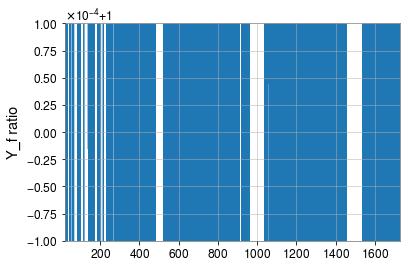

In [39]:
plt.plot(stochastic_mat['freq'], Y_f_new/Y_f_matlab)
plt.xlim(flow, fhigh)
plt.ylabel('Y_f ratio')
plt.ylim(-1e-4+1, 1e-4+1)
plt.xlim(20,1726)
#plt.yscale('linear')
plt.show()

/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py36/lib/python3.6/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


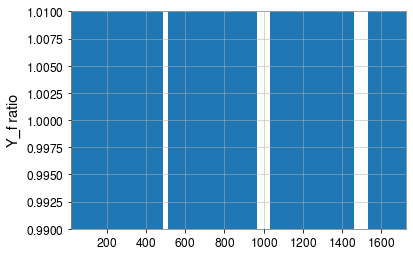

In [40]:
plt.plot(stochastic_mat['freq'], Y_f_new_alt/Y_f_matlab)
plt.xlim(flow, fhigh)
plt.ylabel('Y_f ratio')
plt.ylim(0.99, 1.01)
plt.xlim(20,1726)
#plt.yscale('linear')
plt.show()

/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py36/lib/python3.6/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


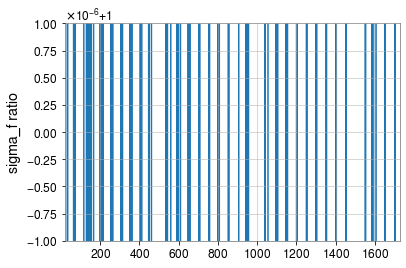

In [41]:
plt.plot(freqs, np.sqrt(var_f_new)/np.real(stochastic_mat['sigma_ff']))
plt.ylim(-1e-6+1, 1e-6+1)
plt.xlim([flow, fhigh])
plt.ylabel('sigma_f ratio')
plt.xlim([20, 1726])
plt.show()

In [42]:
Y_maltab, sigma_matlab = calc_Y_sigma_from_Yf_varf(np.real(stochastic_mat['ptEst_ff']), stochastic_mat['sigma_ff']**2, freqs, alpha, fref)

In [43]:
Y_pyGWB_new, sigma_pyGWB_new = calc_Y_sigma_from_Yf_varf(Y_f_new, var_f_new, freqs, alpha, fref)
Y_pyGWB_new_alt, sigma_pyGWB_new_alt = calc_Y_sigma_from_Yf_varf(Y_f_new_alt, var_f_new_alt, freqs, alpha, fref)

In [44]:
print('Comparing point estimates')
print('\tstochastic.m: %e'%(Y_maltab))
print('\tpyGWB: %e'%(Y_pyGWB))
print('\t%% diff: %f%%'%(100*abs((Y_pyGWB-Y_maltab)/Y_maltab)))

print('Comparing sigmas')
print('\tstochastic.m: %e'%(sigma_matlab))
print('\tpyGWB: %e'%(sigma_pyGWB))
print('\t%% diff: %f%%'%(100*abs((sigma_pyGWB-sigma_matlab)/sigma_matlab)))

Comparing point estimates
	stochastic.m: -2.974485e-06
	pyGWB: -2.933709e-06
	% diff: 1.370886%
Comparing sigmas
	stochastic.m: 1.231366e-06
	pyGWB: 1.226275e-06
	% diff: 0.413453%


In [45]:
print('Comparing point estimates')
print('\tstochastic.m: %e'%(Y_maltab))
print('\tpyGWB: %e'%(Y_pyGWB_new))
print('\t%% diff: %f%%'%(100*abs((Y_pyGWB_new-Y_maltab)/Y_maltab)))

print('Comparing sigmas')
print('\tstochastic.m: %e'%(sigma_matlab))
print('\tpyGWB: %e'%(sigma_pyGWB_new))
print('\t%% diff: %f%%'%(100*abs((sigma_pyGWB_new-sigma_matlab)/sigma_matlab)))

Comparing point estimates
	stochastic.m: -2.974485e-06
	pyGWB: -2.968359e-06
	% diff: 0.205951%
Comparing sigmas
	stochastic.m: 1.231366e-06
	pyGWB: 1.229126e-06
	% diff: 0.181856%


In [46]:
# Calculate Y_f and sigma_f of stochastic analysis for each segment
for ii in range(0,3):
    Y_seg, var_seg = calculate_Yf_varf(freqs, csd[0].value, 
                                   avg_psd_1[ii].value, 
                                   avg_psd_2[ii].value, 
                                   orf, fref, alpha)
    Y_seg[notch_freq] = 0
    var_seg[notch_freq] = 1e80 # some large number
    Y_pyGWB_seg, sigma_pyGWB_seg = calc_Y_sigma_from_Yf_varf(Y_seg, var_seg, freqs, alpha, fref)
    print(sigma_pyGWB_seg/stochastic_mat['ccSigma'][ii]*192)

0.9981974729480685
0.9980478204423848
0.9980603842208191
